# Plot aggregated supplies

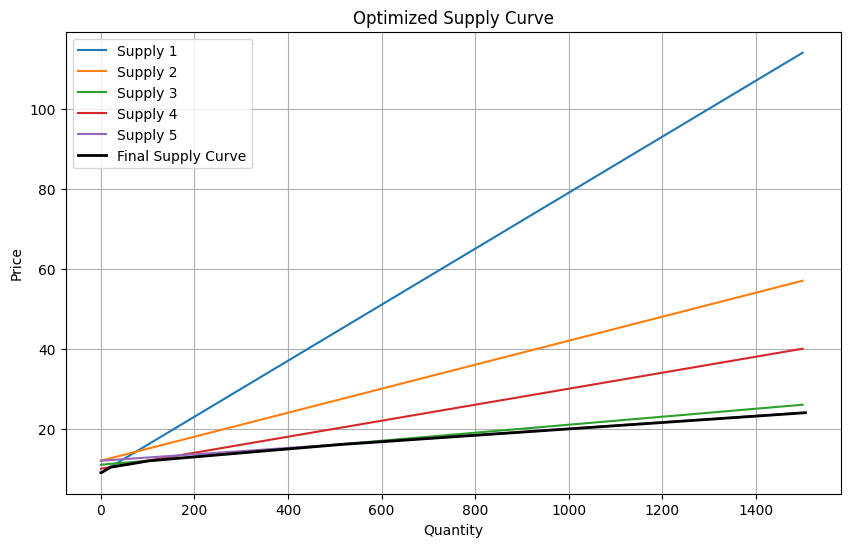

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the bid functions as tuples (slope, intercept)
bids = [(0.07, 9), (0.03, 12), (0.01, 11), (0.02, 10), (0.008, 12)]

# Generate quantities from 0 to 1500 in steps of 1
x = np.linspace(0, 1500, 1501)

# Function to calculate price given slope and intercept
def calculate_price(slope, intercept, x):
    return slope * x + intercept

# Function to calculate intersection point
def find_intersection(slope1, intercept1, slope2, intercept2):
    if slope1 != slope2:
        return (intercept2 - intercept1) / (slope1 - slope2)
    else:
        return np.inf  # Parallel lines never intersect

# Calculate all intersection points
intersections = []
for i in range(len(bids)):
    for j in range(i + 1, len(bids)):
        slope1, intercept1 = bids[i]
        slope2, intercept2 = bids[j]
        intersection = find_intersection(slope1, intercept1, slope2, intercept2)
        if 0 <= intersection <= 1500:
            intersections.append(intersection)

# Sort intersections and remove duplicates
intersections = sorted(set(intersections))

# Add start and end points
intersections = [0] + intersections + [1500]

# Create segments based on intersections
segments = []
for i in range(len(intersections) - 1):
    start = intersections[i]
    end = intersections[i + 1]
    segment_x = np.linspace(start, end, int(end - start) + 1)
    segment_prices = [calculate_price(slope, intercept, segment_x) for slope, intercept in bids]
    min_prices = np.min(segment_prices, axis=0)
    segments.extend(min_prices)

# Generate final quantity array
final_x = np.linspace(0, len(segments) - 1, len(segments))

# Create the final DataFrame
final_df = pd.DataFrame({'x': final_x, 'Final Supply': segments})

# Plot the original supply curves
plt.figure(figsize=(10, 6))
for i, (slope, intercept) in enumerate(bids):
    prices = calculate_price(slope, intercept, x)
    plt.plot(x, prices, label=f'Supply {i + 1}')

# Plot the final supply curve
plt.plot(final_df['x'], final_df['Final Supply'], label='Final Supply Curve', color='black', linewidth=2)

plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Optimized Supply Curve')
plt.legend()
plt.grid(True)
plt.show()


Sorted Bids:
[(0.07, 9), (0.02, 10), (0.01, 11), (0.03, 12), (0.008, 12)]

DataFrame Head:
     x  Supply 1  Supply 2  Supply 3  Supply 4  Supply 5
0  0.0      9.00     10.00     11.00     12.00    12.000
1  1.0      9.07     10.02     11.01     12.03    12.008
2  2.0      9.14     10.04     11.02     12.06    12.016
3  3.0      9.21     10.06     11.03     12.09    12.024
4  4.0      9.28     10.08     11.04     12.12    12.032


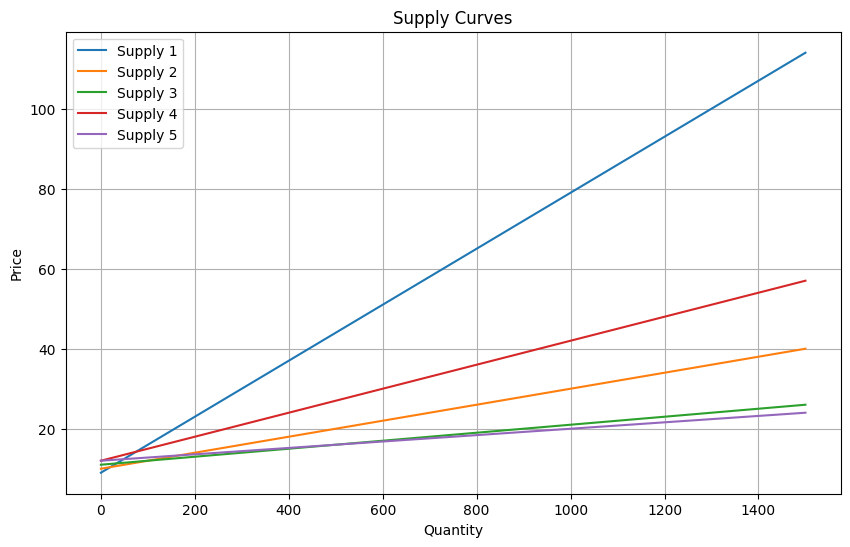

Intersections:
[0, 14.285714285714285, 64.28571428571428, 164.28571428571428, 164.28571428571428]

DataFrame after shifting:
     x  Supply 1  Supply 2  Supply 3  Supply 4  Supply 5
0  0.0      9.00       NaN       NaN       NaN       NaN
1  1.0      9.07       NaN       NaN       NaN       NaN
2  2.0      9.14       NaN       NaN       NaN       NaN
3  3.0      9.21       NaN       NaN       NaN       NaN
4  4.0      9.28       NaN       NaN       NaN       NaN


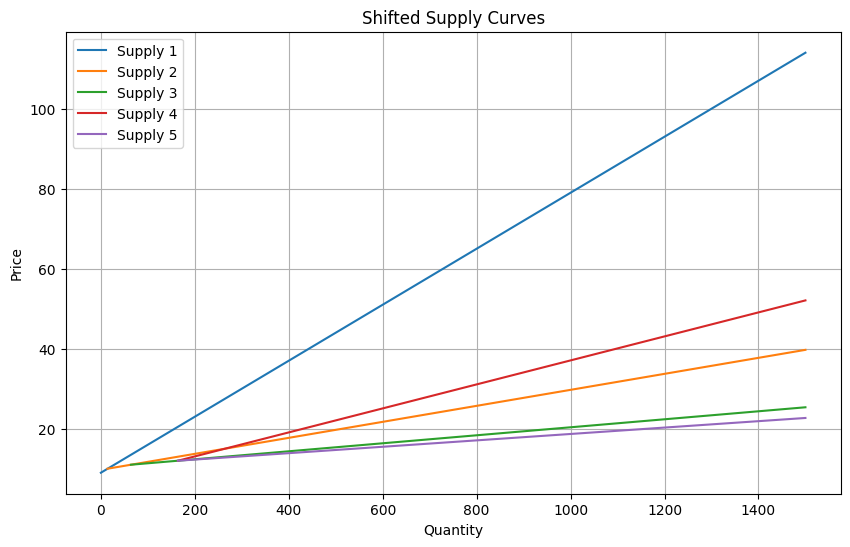

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the bid functions as tuples (slope, intercept)
bids = [(0.07, 9), (0.03, 12), (0.01, 11), (0.02, 10), (0.008, 12)]

# Sort the list of tuples by the second element in ascending order
sorted_bids = sorted(bids, key=lambda x: x[1])

print("Sorted Bids:")
print(sorted_bids)

# Generate quantities from 0 to 1500 in steps of 1
x = np.linspace(0, 1500, 1501)

# Initialize a dictionary to hold the data
data = {'x': x}

# Compute prices for each bid function and add to the dictionary
for i, (slope, intercept) in enumerate(sorted_bids):
    curve_name = f'Supply {i+1}'
    prices = slope * x + intercept
    data[curve_name] = prices

# Create the DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print("\nDataFrame Head:")
print(df.head())

# Plot the supply curves
plt.figure(figsize=(10, 6))
for i in range(len(sorted_bids)):
    plt.plot(df['x'], df[f'Supply {i+1}'], label=f'Supply {i+1}')

plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Supply Curves')
plt.legend()
plt.grid(True)
plt.show()

# Calculate intersections
intersects = [0]
for i in range(len(sorted_bids) - 1):
    intersect = (sorted_bids[i+1][1] - sorted_bids[i][1]) / sorted_bids[i][0]
    intersects.append(intersect)

# Correcting intersections cumulative addition
for i in range(1, len(intersects)):
    intersects[i] += intersects[i-1]

print("Intersections:")
print(intersects)

# Shift the DataFrame columns according to the intersections
for i in range(len(sorted_bids)):
    df[f'Supply {i+1}'] = df[f'Supply {i+1}'].shift(int(intersects[i]))

# Display the DataFrame after shifting
print("\nDataFrame after shifting:")
print(df.head())

# Plot the supply curves after shifting
plt.figure(figsize=(10, 6))
for i in range(len(sorted_bids)):
    plt.plot(df['x'], df[f'Supply {i+1}'], label=f'Supply {i+1}')

plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Shifted Supply Curves')
plt.legend()
plt.grid(True)
plt.show()


# original Optimize allocation

In [77]:
import cvxpy as cp
def optimize_alloc(bids, Q, cap):
    c = np.array([param[0] for param in bids])
    C = np.diag(c)
    D = np.array([param[1] for param in bids])
    n = len(bids)
    A = np.ones(n).T
    G = - np.eye(n)
    h = np.zeros(n)
    I = np.eye(n)

    # non-negativity doesn't strictly hold (small negative allocations might occur)
    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(0.5 * cp.quad_form(x, C) + D.T @ x),
                      [G @ x <= h, A @ x == Q, I @ x <= cap])
    prob.solve()
    allocs = x.value
    social_welfare = prob.value
    # To fix very small values
    for i in range(len(allocs)):
        if allocs[i] < 10 ** (-5):
            allocs[i] = 0

    # only for quadratic case
    sample_winner = np.argmin(allocs)
    marginal_price = bids[sample_winner][0] * min(allocs) + bids[sample_winner][1]
    payments = marginal_price * allocs
    prices = [bids[i][0] * allocs[i] + bids[i][1] for i in range(len(allocs))]
    social_cost = sum([0.5 * bids[i][0] * allocs[i] **2 + bids[i][1] * allocs[i] for i in range(len(allocs))])
    
    print(f"Sample winner: {sample_winner}")
    print(f"Prices: {prices}")
    print(f"Marginal price: {marginal_price}")
    print(f"Status: {prob.status}")
    print(f"Allocations: {x.value}")
    print(f"Q: {sum(allocs)}")
    print(f"Social welfare: {prob.value}")    
    print(f"Social cost: {social_cost}")
    
    
    return allocs, marginal_price, payments, social_welfare

bids = [(0.07, 9), (0.02, 10), (0.03, 12), (0.008, 12), (0.01, 11)]
cap = [1448.4]*len(bids)
Q = 1448.4

allocs, marginal_price, payments, social_welfare = optimize_alloc(bids, Q, cap)

Sample winner: 0
Prices: [15.73673800738051, 15.736738007381156, 15.736738007380879, 15.736738007379357, 15.736738007380099]
Marginal price: 15.73673800738051
Status: optimal
Allocations: [ 96.23911439 286.83690037 124.55793358 467.09225092 473.67380074]
Q: 1448.4
Social welfare: 19418.913192619926
Social cost: 19418.913192619926


# Optimize welfare

In [100]:
import cvxpy as cp
import numpy as np
import torch
from cvxpylayers.torch import CvxpyLayer
from torch.utils.data import TensorDataset, DataLoader

bids = [(0.07, 9), (0.02, 10), (0.03, 12), (0.008, 12), (0.01, 21)]
#bids = [(0.07, 9), (0.02, 10), (0.03, 12), (0.008, 12), (0.01, 11)]
cap = [700]*len(bids)

# Define problem parameters
def optimize_welfare(bids, cap):
    n = len(bids)  # Number of variables
    a = 1  # Parameter a
    b = 1700.0  # Parameter b
    
    # Define the optimization variable
    x = cp.Variable(n)
    
    c = np.array([param[0] for param in bids])
    C = np.diag(c)
    d = np.array([param[1] for param in bids])
    I = np.eye(n)
    
    # Define the objective function
    objective = cp.Maximize(
        -0.5 * a * cp.square(cp.sum(x)) + b * cp.sum(x) - (0.5 * cp.quad_form(x, C) + d.T @ x)
        #-0.5 * a * cp.square(cp.sum(x)) + b * cp.sum(x) - (0.5 * c.T @ cp.square(x) + d.T @ x)
    )
    
    # Define the constraints
    constraints = [I @ x <= cap, x >= 0]
    
    # Define the problem
    problem = cp.Problem(objective, constraints)
    
    # Solve the problem
    problem.solve()
    print(x.value)
    allocs = x.value
    social_welfare = problem.value
    # To fix very small values
    for i in range(len(allocs)):
        if allocs[i] < 1:
            allocs[i] = 0
    # only for quadratic case
    prices = C @ allocs + d
    sample_winner = np.argmax([prices[i] if allocs[i] > 0 else 0 for i in range(n)])
    marginal_price = np.max(prices[sample_winner])
    marginal_price_demand = -a * sum(x.value) + b
    payments = marginal_price * allocs
    Q = sum(allocs)
    
    
    print(f"Sample winner: {sample_winner}")
    print(f"Prices: {prices}")
    print(f"Marginal price: {marginal_price}")
    print(f"Status: {problem.status}")
    print(f"Allocations: {x.value}")
    print(f"Q: {Q}")
    print(f"Social welfare: {problem.value}")
    print(f'Marginal price demand: {marginal_price_demand}')
    
    return allocs, marginal_price, Q, social_welfare

allocs, marginal_price, Q, social_welfare = optimize_welfare(bids, cap)

[ 1.65282859e+02  5.28486129e+02  2.85661225e+02  7.00000000e+02
 -1.40242245e-13]
Sample winner: 2
Prices: [20.56980016 20.56972258 20.56983674 17.6        21.        ]
Marginal price: 20.569836740624098
Status: optimal
Allocations: [165.28285945 528.48612879 285.66122469 700.           0.        ]
Q: 1679.4302129266562
Social welfare: 1419254.9444711334
Marginal price demand: 20.569787073343832


In [ ]:
import cvxpy as cp
import numpy as np
import torch
from cvxpylayers.torch import CvxpyLayer
from torch.utils.data import TensorDataset, DataLoader

bids = [(0.07, 9), (0.02, 10), (0.03, 12), (0.008, 12), (0.01, 11)]
cap = [700] * len(bids)

def optimize_welfare(bids, cap):
    n = len(bids)  # Number of variables
    a = 1  # Parameter a
    b = 1700.0  # Parameter b
    
    # Define the optimization variable
    x = cp.Variable(n)
    
    c = np.array([param[0] for param in bids])
    C = np.diag(c)
    d = np.array([param[1] for param in bids])
    I = np.eye(n)
    
    # Define the objective function
    objective = cp.Maximize(
        -0.5 * a * cp.sum_squares(x) + b * cp.sum(x) - (0.5 * cp.quad_form(x, C) + d.T @ x)
    )
    
    # Define the auxiliary binary variable for conditional constraints
    z = cp.Variable(n, boolean=True)
    
    # Define the constraints
    constraints = [
        I @ x <= cap, 
        x >= 0,
        z >= x / cap,  # Ensure z[i] is 1 if x[i] > 0
        z <= 1,  # Ensure z is binary
        (C @ x + d) <= (-a * cp.sum(x) + b) * np.ones(n) + (1 - z) * 1e6  # Relax constraint when z == 0
    ]
    
    # Define the problem
    problem = cp.Problem(objective, constraints)
    
    # Solve the problem
    try:
        problem.solve()
        if problem.status not in ["infeasible", "unbounded"]:
            # Retrieve solution
            allocs = x.value
            social_welfare = problem.value
            
            # Fix very small values
            allocs = np.where(allocs < 1, 0, allocs)
            
            # Calculate prices and marginal price
            prices = C @ allocs + d
            sample_winner = np.argmax([prices[i] if allocs[i] > 0 else 0 for i in range(n)])
            marginal_price = prices[sample_winner]
            marginal_price_demand = -a * sum(allocs) + b
            payments = marginal_price * allocs
            Q = sum(allocs)
            
            # Print statements
            print(f"Sample winner: {sample_winner}")
            print(f"Prices: {prices}")
            print(f"Marginal price: {marginal_price}")
            print(f"Status: {problem.status}")
            print(f"Allocations: {allocs}")
            print(f"Q: {Q}")
            print(f"Social welfare: {social_welfare}")
            print(f'Marginal price demand: {marginal_price_demand}')
            
            return allocs, marginal_price, payments, social_welfare
        else:
            print("Problem status:", problem.status)
            print("No feasible solution found.")
            return None, None, None, None
    except cp.error.SolverError as e:
        print("Solver Error:", e)
        return None, None, None, None

allocs, marginal_price, payments, social_welfare = optimize_welfare(bids, cap)


In [ ]:
import matplotlib.pyplot as plt

# Gegebene Gebote
bids = [(0.07, 9), (0.02, 10), (0.03, 12), (0.008, 12), (0.01, 11)]

# Erstelle einen Bereich von x-Werten (Angebotsmengen)
x_values = np.linspace(0, 1500, 500)  # Reduzierter Bereich zum Zoomen

# Berechne die Angebotskurven der einzelnen Anbieter
supply_curves = np.array([a * x_values + b for a, b in bids])

# Berechne die aggregierte Angebotskurve
aggregated_supply_curve = np.sum(supply_curves, axis=0)

# Erstelle das Diagramm
plt.figure(figsize=(10, 6))

# Zeichne die Angebotskurven der einzelnen Anbieter
for i, (a, b) in enumerate(bids):
    plt.plot(x_values, a * x_values + b, label=f'Supplier {i+1}')

# Zeichne die aggregierte Angebotskurve
plt.plot(x_values, aggregated_supply_curve, label='Aggregated Supply Curve', linestyle='--', linewidth=2, color='black')

# Füge Beschriftungen und Titel hinzu
plt.xlabel('Quantity (MWh)')
plt.ylabel('Price (€/MWh)')
plt.title('Supply Curves of Individual Suppliers and Aggregated Supply Curve (Zoomed In)')
plt.xlim(0, 1500)  # Begrenze die x-Achse zum Zoomen
plt.xticks(np.arange(0, 1501, 10))
plt.ylim(0,100)   # Begrenze die y-Achse zum Zoomen
plt.legend()

# Zeige das Diagramm an
plt.show()


# Learn Parameters

In [ ]:
def orig_opt():
    m = 5
    
    a = cp.Parameter(m,nonneg=True)
    b = cp.Parameter(nonneg=True)
    
    # Define the optimization variable
    x = cp.Variable(m)
    
    # Define the parameters
    c = cp.Parameter(m, nonneg=True)
    d = cp.Parameter(m, nonneg=True)
    
    # Define the objective function
    objective = -0.5 * cp.sum(cp.multiply(a, cp.square(x))) + b * cp.sum(x) - cp.sum(0.5 * cp.multiply(c[-1], cp.square(x[-1])) + cp.multiply(d[-1],  x[-1]))
    # Define the constraints
    constraints = [x >= 0, cp.sum( cp.multiply(x, c + a) + d) == b]
    for i in range(m-1):
        objective -= 0.5 * c[i] * cp.square(x[i]) + d[i] * x[i]
     
    # Define the problem
    problem = cp.Problem(cp.Maximize(objective), constraints)
    
    print("DCP and DPP compliant:", problem.is_dcp(dpp=True))
    
    
    # Create the CVXPY layer
    cvxpylayer = CvxpyLayer(problem, parameters=[a, b, c, d], variables=[x])
    
    return cvxpylayer

In [ ]:
optim = orig_opt()

In [ ]:
def get_data(N, m, c, d):
    a = torch.ones(N, m, dtype=torch.float32)
    b = torch.ones(N, dtype=torch.float32) * 1700.0
    y = optim(c, d)[0]
    c = c.repeat(N, 1)
    d = d.repeat(N, 1)
    y = y * (c + a) + d
    y = y * (torch.rand_like(y, dtype=torch.float32) + torch.ones_like(y, dtype=torch.float32) * 0.5)
    y = y * b[:, None] / y.sum(axis=1)[:, None]
    return torch.cat([a, b.unsqueeze(1)], axis=1), y
m = 5
c_t = torch.tensor([0.07, 0.02, 0.03, 0.008, 0.01], dtype=torch.float32)
d_t = torch.tensor([9, 10, 12, 12, 11], dtype=torch.float32)

X, Y = get_data(500, m, c_t, d_t)
print(X[:,0:5])
print(Y)
X_val, Y_val = get_data(250, m, c_t, d_t)

Y_t = optim(c_t, d_t)[0]

In [ ]:
def get_data(N, m, c, d):
    a = torch.rand(N, m, dtype=torch.float32)
    b = torch.rand(N, dtype=torch.float32) + torch.ones(N, dtype=torch.float32) * 1700.0
    y = optim(a, b, c, d)[0]
    c = c.repeat(N, 1)
    d = d.repeat(N, 1)
    y = y * (c + a) + d
    y = y * (torch.rand_like(y, dtype=torch.float32) + torch.ones_like(y, dtype=torch.float32) * 0.5)
    y = y * b[:, None] / y.sum(axis=1)[:, None]
    return torch.cat([a, b.unsqueeze(1)], axis=1), y
m = 5
a_t = torch.tensor([1.0]*m, dtype=torch.float32)
b_t = torch.tensor([1700.0], dtype=torch.float32)
c_t = torch.tensor([0.07, 0.02, 0.03, 0.008, 0.01], dtype=torch.float32)
d_t = torch.tensor([9, 10, 12, 12, 11], dtype=torch.float32)

X, Y = get_data(500, 5, c_t, d_t)
print(X[:,0:5])
print(Y)
X_val, Y_val = get_data(250, 5, c_t, d_t)

Y_t = optim(a_t, b_t, c_t, d_t)[0]

In [ ]:
def fit(loss, params, X, Y, Xval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None):
    """

    Arguments:
        loss: given x and y in batched form, evaluates loss.
        params: list of parameters to optimize.
        X: input data, torch tensor.
        Y: output data, torch tensor.
        Xval: input validation data, torch tensor.
        Yval: output validation data, torch tensor.
    """

    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    opt = opt(params, **opt_kwargs)

    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        with torch.no_grad():
            val_losses.append(loss(Xval, Yval).item())
        if verbose:
            print("%03d | %3.5f" % (epoch + 1, val_losses[-1]))
        batch = 1
        train_losses.append([])
        for Xbatch, Ybatch in train_loader:
            opt.zero_grad()
            l = loss(Xbatch, Ybatch)
            l.backward()
            opt.step()
            train_losses[-1].append(l.item())
            if verbose:
                print("batch %03d / %03d | %3.5f" %
                      (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
            if callback is not None:
                callback()
    return val_losses, train_losses

In [ ]:
loss_fn = torch.nn.MSELoss()

In [ ]:
torch.manual_seed(1)
c = torch.rand(m, dtype=torch.float32)
c.requires_grad_(True)
d = torch.rand(m, dtype=torch.float32) * 10
d.requires_grad_(True)
def loss(X, Y, c, d):
    Yhat = optim(X[:,0:5], X[:,5], c, d)[0]
    return loss_fn(Y, Yhat)

def callback():
    c.data = torch.max(c.data, torch.zeros_like(c.data))
    d.data = torch.max(d.data, torch.zeros_like(d.data))

print(loss(X, Y, c_t, d_t), loss(X_val, Y_val, c_t, d_t))
print(loss(X, Y, c, d), loss(X_val, Y_val, c, d))

val_losses, train_losses = fit(lambda X, Y: loss(X, Y, c, d), [c, d], X, Y, X_val, Y_val,
                               opt=torch.optim.Adam, opt_kwargs={"lr":1e-2},
                               batch_size=5, epochs=100, verbose=True, callback=callback)

In [56]:
c

NameError: name 'c' is not defined

In [57]:
c_t

NameError: name 'c_t' is not defined

In [58]:
d

NameError: name 'd' is not defined

In [59]:
d_t

NameError: name 'd_t' is not defined

In [60]:
theta = torch.zeros(m + 1, m, dtype=torch.float32)
theta0 = torch.zeros(m, requires_grad=True, dtype=torch.float32)
theta.requires_grad_(True)
opt = torch.optim.LBFGS([theta, theta0], max_iter=500)
l = torch.nn.KLDivLoss()

def closure():
    opt.zero_grad()
    loss = l(torch.nn.LogSoftmax()(X @ theta + theta0), Y / Y.sum(1)[:,None])
    loss.backward()
    return loss

opt.step(closure)

NameError: name 'torch' is not defined

NameError: name 'loss_fn' is not defined

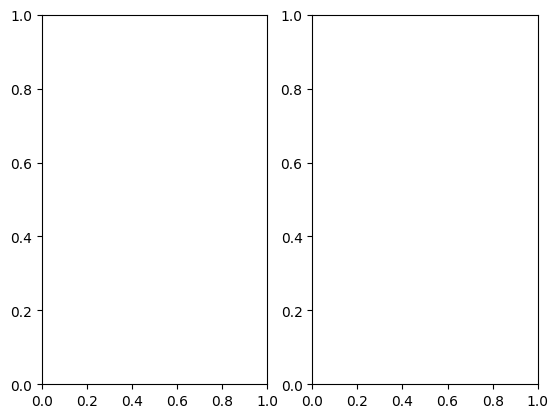

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
#fig.set_size_inches(5.485, 1.8)

ax[0].axhline(loss_fn(torch.nn.Softmax()(X_val @ theta + theta0) * X_val[:,0][:,None], Y_val).item(), linestyle='-.', c='black', label='LR')
ax[0].plot(val_losses, c='black', label='COM')
ax[0].axhline(loss(X_val, Y_val, c_t, d_t).item(), linestyle='--', c='black', label='true')
ax[0].legend()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("validation loss")

ax[1].plot(c.detach().numpy(), c='black', label='c learned')
ax[1].plot(d.detach().numpy(), c='green', label='d learned')
ax[1].plot(c_t.detach().numpy(), '--', c='black', label='c true')
ax[1].plot(d_t.detach().numpy(), '--', c='green', label='d true')
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("$\\theta_i$")
ax[1].legend()

plt.tight_layout()

#plt.savefig("figures/resource_allocation.pdf")

In [ ]:
c

In [ ]:
c_t

In [ ]:
d

In [ ]:
d_t